# Setup and preprocess the data

In [1]:
import scanpy as sc
import pandas as pd
import scipy.io as io

In [2]:
data_path = '/mnt/c/Users/minch/Data/bmdc/'

### Read the data from 0 hour

In [5]:
genes = pd.read_csv(
    data_path + 'GSM2396857_dc_0hr_genenames.csv', index_col=0)
var_df = pd.DataFrame(index=genes['0'].str.split('_').str[1])
var_df['gene_id'] = genes['0'].str.split('_').str[0].tolist()

cells = pd.read_csv(
    data_path + 'GSM2396857_dc_0hr_cellnames.csv', index_col=0)
obs_df = pd.DataFrame(index=cells['0'])
obs_df['cell'] = cells['0'].tolist()

mapping = pd.read_csv(data_path + 'GSM2396857_dc_0hr_cbc_gbc_dict.csv', header=None)
mapping['cell'] = mapping[1].str.split(', ')
mapping = mapping.explode(column='cell').rename(columns={0:'guide'})[['cell', 'guide']]
guides = mapping['guide'].drop_duplicates().tolist()

print(obs_df.shape)
obs_df = obs_df.merge(mapping, on='cell', how='left').astype(str)
obs_df = pd.DataFrame(obs_df.groupby('cell').guide.apply(list))
obs_df['guide_string'] = obs_df['guide'].apply(lambda x: '-'.join(x))
print(obs_df.shape)

X = io.mmread(data_path + 'GSM2396857_dc_0hr.mtx.txt').tocsr()

adata0 = sc.AnnData(X=X.T, obs=obs_df, var=var_df)


(33063, 1)
(33063, 2)


/home/mincheoly/miniconda3/envs/scvi/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


### Read the data from 3 hr

In [6]:
genes = pd.read_csv(
    data_path + 'GSM2396856_dc_3hr_genenames.csv', index_col=0)
var_df = pd.DataFrame(index=genes['0'].str.split('_').str[1])
var_df['gene_id'] = genes['0'].str.split('_').str[0].tolist()

cells = pd.read_csv(
    data_path + 'GSM2396856_dc_3hr_cellnames.csv', index_col=0)
obs_df = pd.DataFrame(index=cells['0'])
obs_df['cell'] = cells['0'].tolist()

mapping = pd.read_csv(data_path + 'GSM2396856_dc_3hr_cbc_gbc_dict_lenient.csv', header=None)
mapping['cell'] = mapping[1].str.split(', ')
mapping = mapping.explode(column='cell').rename(columns={0:'guide'})[['cell', 'guide']]
guides = mapping['guide'].drop_duplicates().tolist()

print(obs_df.shape)
obs_df = obs_df.merge(mapping, on='cell', how='left').astype(str)
obs_df = pd.DataFrame(obs_df.groupby('cell').guide.apply(list))
obs_df['guide_string'] = obs_df['guide'].apply(lambda x: '-'.join(x))
print(obs_df.shape)

X = io.mmread(data_path + 'GSM2396856_dc_3hr.mtx.txt').tocsr()

adata3 = sc.AnnData(X=X.T, obs=obs_df, var=var_df)




(32777, 1)
(32777, 2)


/home/mincheoly/miniconda3/envs/scvi/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


### Combine datasets

In [7]:
adata0.obs['tp'] = '0hr'
adata3.obs['tp'] = '3hr'

adata0.var_names_make_unique()
adata3.var_names_make_unique()
overlap_genes = adata0.var[[]].copy().join(adata3.var[[]].copy(), how='inner').index.tolist()

adata0 = adata0[:, overlap_genes]
adata3 = adata3[:, overlap_genes]

adata_combined = adata0.concatenate(adata3)
adata_combined.obs.drop('guide', inplace=True, axis=1)
adata_combined.write(data_path + 'bmdc.h5ad')

/home/mincheoly/miniconda3/envs/scvi/lib/python3.10/site-packages/anndata/_core/anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


### Preprocess and filter

In [3]:
adata = sc.read(data_path + 'bmdc.h5ad')
adata = adata[adata.obs['tp'] == '3hr'].copy()
adata = adata[adata.obs['guide_string']!='nan', :].copy()
adata.obs['WT'] = adata.obs['guide_string'].str.contains('NTC') & (adata.obs.guide_string.apply(lambda x: len(x.split('-'))) == 1)
adata.obs['KO'] = (~adata.obs['guide_string'].str.contains('NTC')).astype(int)

In [4]:
adata.obs['n_counts'] = adata.X.sum(axis=1)


In [5]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [6]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

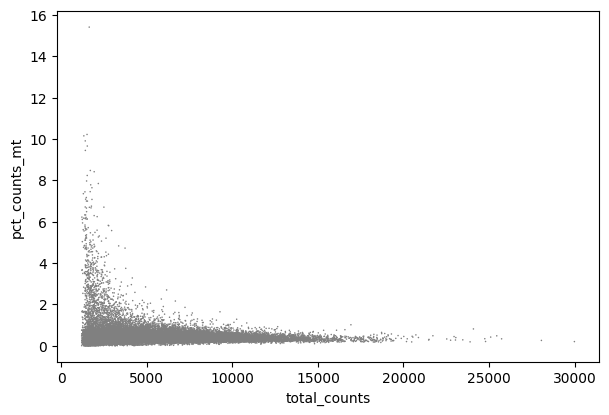

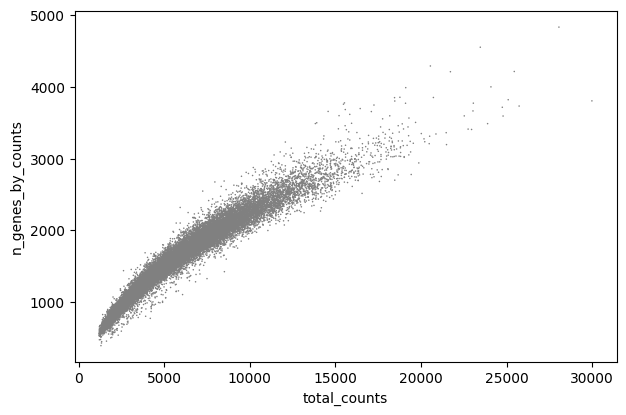

In [7]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [8]:
adata = adata[adata.obs.pct_counts_mt < 2, :]


In [9]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

/home/mincheoly/miniconda3/envs/scvi/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [10]:
sc.tl.pca(adata, svd_solver='arpack')

In [11]:
adata.write(data_path + 'processed_bmdc.h5ad')

### Generate count AnnData with PCA and other metadata

In [12]:
adata_raw = sc.read(data_path + 'bmdc.h5ad')
adata = sc.read(data_path + 'processed_bmdc.h5ad')
adata_raw = adata_raw[adata.obs.index, :]
adata_raw.obs = adata.obs.copy()
adata_raw.obsm = adata.obsm.copy()

adata_raw.write(data_path + 'processed_bmdc_counts.h5ad')
adata_raw[:, adata.var.index].write(data_path + 'processed_bmdc_hvg_counts.h5ad')


In [13]:
adata_raw.layers['counts'] = adata_raw.X

In [14]:
adata_raw[:, adata.var.index].write(data_path + 'processed_bmdc_hvg_counts.h5ad')
